In [3]:
import mat73
import glob
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.signal import butter,lfilter
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from scipy.signal import welch
from scipy.signal import filtfilt, freqz
import numpy as np
import gc
import itertools
from collections import deque 
from sklearn.preprocessing import LabelEncoder
# #from keras.utils import np_utils
# from keras.models import Sequential, Model, load_model
# from keras.layers import Dense, Conv1D, Flatten, Dropout,GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, Input, GaussianNoise, LSTM, BatchNormalization, concatenate, Activation
# from keras import regularizers
# from keras.optimizers import Adam, Nadam, SGD
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, auc
import sklearn.metrics as mets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import itertools
import matplotlib.pyplot as plt
# from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# from keras import initializers
import signal
# import tensorflow as tf    
# import keras.backend as kb
from sklearn.utils import shuffle
from tqdm import tqdm
from collections import Counter
import pywt
from pywt import Wavelet
from pywt import wavedec
import re
import sys

# tf.compat.v1.enable_eager_execution()

In [4]:
def countlist(random_list):
    retlist = []
    count = 0
    # Avoid IndexError for  random_list[i+1]
    for i in range(len(random_list) - 1):
        # Check if the next number is consecutive
        if random_list[i] + 1 == random_list[i+1]:
            count += 1
        else:
            # If it is not append the count and restart counting
            retlist.append(count)
            count = 1
    # Since we stopped the loop one early append the last count
    retlist.append(count)
    return retlist

In [5]:
def downsample(factor,values):
    buffer_ = deque([],maxlen=factor)
    downsampled_values = []
    for i,value in enumerate(values):
        if i!=0 and i%factor==0:
            #for j in buffer_:
                #if values[j] > -70 and values[j] < 70:
                    #downsampled_values.append(j)
            downsampled_values.append(i)
        else:
            buffer_.appendleft(i)
    return np.array(downsampled_values)

In [6]:
def ratio(data, output=False):
    # get the mean of the absolute values
    data = data.abs().mean()
    # get a list of the index
    decimation_levels = list(data.index)

    ratio_data = pd.Series(index=data.index)
    for level_no in range(0, len(decimation_levels)):
        # for the first decimation
        if level_no == 0:
            ratio_data.loc[decimation_levels[level_no]] = \
                data.loc[decimation_levels[level_no]] / data.loc[decimation_levels[level_no + 1]]

        # for the last decimation
        elif level_no == len(decimation_levels) - 1:
            ratio_data.loc[decimation_levels[level_no]] = \
                data.loc[decimation_levels[level_no]] / data.loc[decimation_levels[level_no - 1]]
        else:
            before = data.loc[decimation_levels[level_no - 1]]
            after = data.loc[decimation_levels[level_no + 1]]
            mean_data = (before + after) / 2

            ratio_data.loc[decimation_levels[level_no]] = \
                data.loc[decimation_levels[level_no]] / mean_data

    ratio_data.index += '_Ratio'

    if output:
        pd.display(ratio_data)

    return ratio_data

def coeff_std(data, output=False):
    # get the standard deviation of the coeficients
    std_data = data.std()

    std_data.index += '_std'

    return std_data


def ave(data):
    mean_data = data.mean()

    mean_data.index += '_mean'

    return mean_data


def mean_abs(data):
    # get the mean of the absolute values
    mean_abs_data = data.abs().mean()

    mean_abs_data.index += '_mean_abs'

    return mean_abs_data

def minus_small(data):
    # find the smallest value for each data column (channel)...
    min_val = data.min()
    # ...and subtract it from all the data in the column and add one
    data = data.subtract(min_val).add(1)

    return data

def log_sum(data, output=False):
    absolute_sums = data.sum()
    # ...and subtract it from all the data in the column and add one
    absolute_sums_minus = minus_small(absolute_sums)
    # find the log of each elecment (datapoint)
    absolute_sums_log = absolute_sums_minus.apply(np.log)
    absolute_sums_log.index += '_LSWT'

    if output:
        pd.display(absolute_sums_log)

    return absolute_sums_log


def wavelet_decompose(data, output=False):
    # decompose data into coefficients
    level = 4

    # transpose the data
    data_t = data.transpose()

    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t, wavelet='db4', level=level, mode='per')

    # make a list of the component names (later column rows)
    nums = list(range(1, level + 1))
    names = []
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))

    # reverse the names so it counts down
    names = names[::-1]

    # make an empy dataframe
    wavelets = pd.DataFrame()
    
    # for each array in the list of arrays
    for i, array in enumerate(coeffs_list):
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array)
        # name the column the appropriate level name
        level_df.columns = [names[i]]
        # if the wavelets df is empty...
        if wavelets.empty:
            # ... make the first level df the wavelets df
            wavelets = level_df
        # ..otherwise...
        else:
            # ... add the next levels df to another column
            wavelets = pd.concat([wavelets, level_df], axis=1)

    # remove the AN levels
    regex = re.compile('D')
    bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
    decom_wavelets = wavelets.drop(bad_items, axis=1)

    if output:
        pd.display(decom_wavelets)
        
#     return pd.concat([ratio(decom_wavelets).to_frame().T, log_sum(decom_wavelets).to_frame().T, 
#                ave(decom_wavelets).to_frame().T, mean_abs(decom_wavelets).to_frame().T], axis=1)
    return pd.concat([ratio(decom_wavelets), log_sum(decom_wavelets), ave(decom_wavelets),
                      mean_abs(decom_wavelets)])

def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band
    #print(low, sf, (2 / low)*sf)
    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd


def power_measures(data, sample_rate, output=False):
    bandpasses = [[[0.5,3],'power_delta'],
                  [[3,6],'power_theta'],
                  [[6,9],'power_alpha'],
                  [[9,16],'power_beta'],
                  [[16,24],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    welch_df = welch_df.T
    
    if output:
        display(welch_df)
    
    return welch_df

In [7]:
# data = mat73.loadmat('./mice_data/unlabelled_data/NewLabelledData/20240209_M1_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'], label='Seizure')
# plt.legend()
# plt.show()

In [6]:
# i = 2
# j = 0
# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M1_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[5000000:10000000], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[5000000:10000000], label='Seizure')
# plt.legend()
# plt.show()

# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M1_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[5000000:6000000], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[5000000:6000000], label='Seizure')
# plt.legend()
# plt.show()

# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M1_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[5270000:5350000], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[5270000:5350000], label='Seizure')
# plt.legend()
# plt.show()

# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M2_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'], label='Seizure')
# plt.legend()
# plt.show()

# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M2_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[5000000:6000000], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[5000000:6000000], label='Seizure')
# plt.legend()
# plt.show()

# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M2_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[5700000:5900000], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[5700000:5900000], label='Seizure')
# plt.legend()
# plt.show()

# data = mat73.loadmat('/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/20240209_M2_MAT.mat')
# mdf = pd.DataFrame.from_dict(data['rec'])
# del data
# #mdf['Day'] = j+1
# #plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
# plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[5750000:5770000], label='Benign')
# plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[5750000:5770000], label='Seizure')
# plt.legend()
# plt.show()

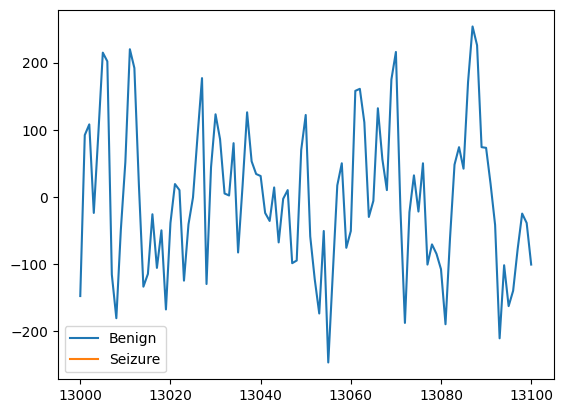

In [8]:
downsample_freq = 100
i = 2
j = 0

data = mat73.loadmat('./mice_data/unlabelled_data/NewLabelledData/20240209_M1_MAT.mat')
mdf = pd.DataFrame.from_dict(data['rec'])
del data
downsampled_idx = downsample(int(1000/downsample_freq), mdf['ecog'])
downsampled_mdf = mdf.iloc[downsampled_idx].reset_index(drop=True)
plt.plot(downsampled_mdf[downsampled_mdf['SWDlabel']==False]['ecog'].loc[13000:13100], label='Benign')
plt.plot(downsampled_mdf[downsampled_mdf['SWDlabel']==True]['ecog'].loc[13000:13100], label='Seizure')
plt.legend()
plt.show()

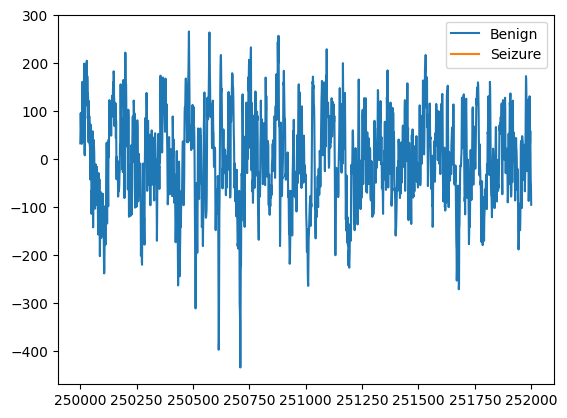

In [9]:
i = 2
j = 0
data = mat73.loadmat('./mice_data/unlabelled_data/NewLabelledData/20240209_M1_MAT.mat')
mdf = pd.DataFrame.from_dict(data['rec'])
del data

#plt.set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
plt.plot(mdf[mdf['SWDlabel']==False]['ecog'].loc[250000:252000], label='Benign')
plt.plot(mdf[mdf['SWDlabel']==True]['ecog'].loc[250000:252000], label='Seizure')
plt.legend()
plt.show()

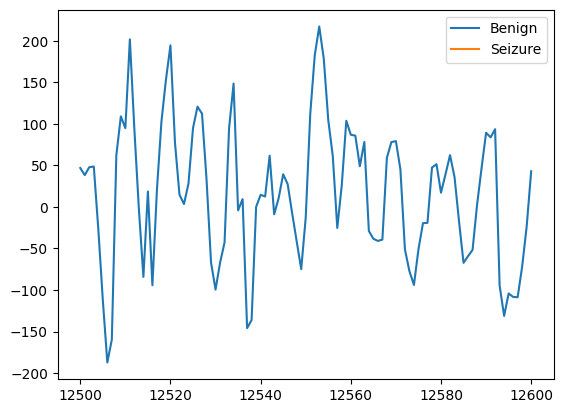

In [10]:
downsample_freq = 50
i = 2
j = 0

data = mat73.loadmat('./mice_data/raw_data/Day' + str(j+1) + '_M' + str(i+1) + '.mat')
mdf = pd.DataFrame.from_dict(data['rec'])
del data
mdf['Mouse'] = i+1
downsampled_idx = downsample(int(1000/downsample_freq), mdf['ecog'])
downsampled_mdf = mdf.iloc[downsampled_idx].reset_index(drop=True)
plt.plot(downsampled_mdf[downsampled_mdf['SWDlabel']==False]['ecog'].loc[12500:12600], label='Benign')
plt.plot(downsampled_mdf[downsampled_mdf['SWDlabel']==True]['ecog'].loc[12500:12600], label='Seizure')
plt.legend()
plt.show()

In [10]:
# _, ax = plt.subplots(8, 5, sharex = True, sharey = True, figsize = (21,21), constrained_layout = True)

# for i in range(8):
#     for j in range(5):
#         print("Mouse "+ str(i+1) + "/Day " + str(j+1))
#         data = mat73.loadmat('./mice_data/raw_data/Day' + str(j+1) + '_M' + str(i+1) + '.mat')
#         mdf = pd.DataFrame.from_dict(data['rec'])
#         del data
#         mdf['Day'] = j+1
#         ax[i,j].set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
#         ax[i,j].boxplot(countlist(mdf[mdf['SWDlabel']==True].index))
#         ax[i,j].axis(ymin=0,ymax=20000)
#         gc.collect()

# plt.show()

In [11]:
# _, ax = plt.subplots(8, 5, sharex = True, sharey = True, figsize = (21,21), constrained_layout = True)

# for i in range(8):
#     for j in range(5):
#         print("Mouse "+ str(i+1) + "/Day " + str(j+1))
#         data = mat73.loadmat('/scratch/ss4jg/Mice data/Matfiles/Day' + str(j+1) + '_M' + str(i+1) + '.mat')
#         mdf = pd.DataFrame.from_dict(data['rec'])
#         del data
#         mdf['Day'] = j+1
#         ax[i,j].set_title("Mouse "+ str(i+1) + "/Day " + str(j+1), fontsize=20)
#         f, Pxx_den = signal.periodogram(mdf[mdf['SWDlabel']==True]['ecog'].to_numpy(), 1000)
#         ax[i,j].plot(f, 10*np.log10(Pxx_den))
#         ax[i,j].axis(xmin=0,xmax=150)
#         ax[i,j].axis(ymin=-40,ymax=50)
#         gc.collect()

# plt.show()

In [12]:
# _, ax = plt.subplots(2, 4, sharex = True, sharey = True, figsize = (20,10), constrained_layout = True)

# for i in range(8):
#     x = [1, 2, 3, 4, 5]
#     y = [0, 0, 0, 0, 0]
#     for j in range(5):
#         print("Mouse "+ str(i+1) + "/Day " + str(j+1))
#         data = mat73.loadmat('/scratch/ss4jg/Mice data/Matfiles/Day' + str(j+1) + '_M' + str(i+1) + '.mat')
#         mdf = pd.DataFrame.from_dict(data['rec'])
#         del data
#         mdf['Day'] = j+1
#         y[j] = len(countlist(mdf[mdf['SWDlabel']==True].index))
#         gc.collect()
#     ax[int(i/4),i%4].set_title("Mouse "+ str(i+1))
#     ax[int(i/4),i%4].bar(x, y)
#     ax[int(i/4),i%4].set_ylabel('Number of Seizures')
#     ax[int(i/4),i%4].set_xlabel('Day')
# plt.show()

In [11]:
total_seizures = 0
seizure_durations = []
non_seizure_durations = []
nmice = 10
for i in range(nmice):
    data = mat73.loadmat('./mice_data/unlabelled_data/NewLabelledData/20240209_M' + str(i+1) + '_MAT.mat')
    mdf = pd.DataFrame.from_dict(data['rec'])
    del data
    total_seizures += len(countlist(mdf[mdf['SWDlabel']==True].index))
    seizure_durations.append(countlist(mdf[mdf['SWDlabel']==True].index))
    non_seizure_durations.append(countlist(mdf[mdf['SWDlabel']==False].index))
    print("Minimum ECOG value for Mouse " + str(i+1) + " (seizure): " + str(np.min(mdf[mdf['SWDlabel']==True]['ecog'].to_numpy())))
    print("Maximum ECOG value for Mouse " + str(i+1) + " (seizure): " + str(np.max(mdf[mdf['SWDlabel']==True]['ecog'].to_numpy())))
    print("Average ECOG value for Mouse " + str(i+1) + " (seizure): " + str(np.average(mdf[mdf['SWDlabel']==True]['ecog'].to_numpy())))
    print("Minimum ECOG value for Mouse " + str(i+1) + " (non-seizure): " + str(np.min(mdf[mdf['SWDlabel']==False]['ecog'].to_numpy())))
    print("Maximum ECOG value for Mouse " + str(i+1) + " (non-seizure): " + str(np.max(mdf[mdf['SWDlabel']==False]['ecog'].to_numpy())))
    print("Average ECOG value for Mouse " + str(i+1) + " (non-seizure): " + str(np.average(mdf[mdf['SWDlabel']==False]['ecog'].to_numpy())))
    gc.collect()

Minimum ECOG value for Mouse 1 (seizure): -3322.988037109375
Maximum ECOG value for Mouse 1 (seizure): 1324.977294921875
Average ECOG value for Mouse 1 (seizure): -0.0701663607631728
Minimum ECOG value for Mouse 1 (non-seizure): -3533.0
Maximum ECOG value for Mouse 1 (non-seizure): 1350.923583984375
Average ECOG value for Mouse 1 (non-seizure): -0.2975053957875251
Minimum ECOG value for Mouse 2 (seizure): -2757.991276399715
Maximum ECOG value for Mouse 2 (seizure): 1153.1630860335736
Average ECOG value for Mouse 2 (seizure): -14.915963416971149
Minimum ECOG value for Mouse 2 (non-seizure): -7980.744384996575
Maximum ECOG value for Mouse 2 (non-seizure): 9231.329447343836
Average ECOG value for Mouse 2 (non-seizure): -14.463225651583697
Minimum ECOG value for Mouse 3 (seizure): -3582.8217391525386
Maximum ECOG value for Mouse 3 (seizure): 1283.1865084640638
Average ECOG value for Mouse 3 (seizure): -0.12569493546011995
Minimum ECOG value for Mouse 3 (non-seizure): -3495.8221175474746
Ma

In [12]:
avg_seizures = total_seizures / nmice
avg_seizure_duration = np.mean(list(itertools.chain.from_iterable(seizure_durations)))
avg_non_seizure_duration = np.mean(list(itertools.chain.from_iterable(non_seizure_durations)))
total_seizure_durations = list(map(sum, seizure_durations))
total_non_seizure_durations = list(map(sum, non_seizure_durations))
print("Number of Mice: " + str(nmice))
print("Average Number of Seizures per Day: " + str(avg_seizures))
print("Average Length of Seizure: " + str(avg_seizure_duration/400) + " seconds.")
print("Average Length of Non-Seizure Period: " + str(avg_non_seizure_duration/400) + " seconds.")
print("Average time spent in Seizure State: " + str(np.mean(total_seizure_durations)/24000) + " minutes.")
print("Average time spent in Non-Seizure State: " + str(np.mean(total_non_seizure_durations)/1440000) + " hours.")

Number of Mice: 10
Average Number of Seizures per Day: 189.0
Average Length of Seizure: 5.076608465608466 seconds.
Average Length of Non-Seizure Period: 111.86358350951373 seconds.
Average time spent in Seizure State: 15.991316666666666 minutes.
Average time spent in Non-Seizure State: 5.879052777777778 hours.


In [13]:
downsample_freq = 50
downsampled_mdf_combined = pd.DataFrame()
fs = 400
cutoff = 70 #Hz
nq = 0.5 * fs
ncutoff = cutoff/nq
b,a = butter(5,ncutoff,btype = 'low')
nmice = 10

for i in range(nmice):
    # for j in range(5):
    data = mat73.loadmat('./mice_data/unlabelled_data/NewLabelledData/20240209_M' + str(i+1) + '_MAT.mat')
        # data = mat73.loadmat('./mice_data/raw_data/Day' + str(j+1) + '_M' + str(i+1) + '.mat')
    mdf = pd.DataFrame.from_dict(data['rec'])
    del data
    mdf['Mouse'] = i+1
    num_seizures = len(countlist(mdf[mdf['SWDlabel']==True].index))

    # Apply low pass filter
    #x = np.array(mdf['ecog']).reshape(mdf.shape[0],1)
    #mdf['ecog'] = lfilter(b,a,x)

    # Downsample
    downsampled_idx = downsample(int(fs/downsample_freq), mdf['ecog'])
    downsampled_mdf = mdf.loc[downsampled_idx].reset_index(drop=True)
    downsampled_mdf_combined = pd.concat([downsampled_mdf_combined, downsampled_mdf], ignore_index=True)
    num_downsampled_seizures = len(countlist(downsampled_mdf[downsampled_mdf['SWDlabel']==True].index))

    diff_seizures = num_seizures - num_downsampled_seizures
    print("Missed seizures after downsampling for Mouse " + str(i+1) + f" Day: {j+1}" + str(diff_seizures)) 

print(downsampled_mdf_combined)

Missed seizures after downsampling for Mouse 1 Day: 10
Missed seizures after downsampling for Mouse 2 Day: 10
Missed seizures after downsampling for Mouse 3 Day: 10
Missed seizures after downsampling for Mouse 4 Day: 10
Missed seizures after downsampling for Mouse 5 Day: 10
Missed seizures after downsampling for Mouse 6 Day: 10
Missed seizures after downsampling for Mouse 7 Day: 10
Missed seizures after downsampling for Mouse 8 Day: 10
Missed seizures after downsampling for Mouse 9 Day: 10
Missed seizures after downsampling for Mouse 10 Day: 10
          SWDlabel         ecog     fs   mID  Mouse
0            False -1091.000000  400.0   1.0      1
1            False -1091.000000  400.0   1.0      1
2            False -1091.000000  400.0   1.0      1
3            False -1091.000000  400.0   1.0      1
4            False -1091.000000  400.0   1.0      1
...            ...          ...    ...   ...    ...
11062028      True   -96.061688  400.0  10.0     10
11062029      True  -137.013095  

In [14]:
total_seizures = 0
seizure_durations = []
non_seizure_durations = []
for i in range(nmice):
    mi_df = downsampled_mdf_combined[downsampled_mdf_combined['Mouse'] == i+1]
    total_seizures += len(countlist(mi_df[mi_df['SWDlabel']==True].index))
    seizure_durations.append(countlist(mi_df[mi_df['SWDlabel']==True].index))
    non_seizure_durations.append(countlist(mi_df[mi_df['SWDlabel']==False].index))
    print("Minimum ECOG value for Mouse " + str(i+1) + " (seizure): " + str(np.min(mi_df[mi_df['SWDlabel']==True]['ecog'].to_numpy())))
    print("Maximum ECOG value for Mouse " + str(i+1) + " (seizure): " + str(np.max(mi_df[mi_df['SWDlabel']==True]['ecog'].to_numpy())))
    print("Average ECOG value for Mouse " + str(i+1) + " (seizure): " + str(np.average(mi_df[mi_df['SWDlabel']==True]['ecog'].to_numpy())))
    print("Minimum ECOG value for Mouse " + str(i+1) + " (non-seizure): " + str(np.min(mi_df[mi_df['SWDlabel']==False]['ecog'].to_numpy())))
    print("Maximum ECOG value for Mouse " + str(i+1) + " (non-seizure): " + str(np.max(mi_df[mi_df['SWDlabel']==False]['ecog'].to_numpy())))
    print("Average ECOG value for Mouse " + str(i+1) + " (non-seizure): " + str(np.average(mi_df[mi_df['SWDlabel']==False]['ecog'].to_numpy())))
        
avg_seizures = total_seizures / nmice
min_seizure_duration = np.min(list(itertools.chain.from_iterable(seizure_durations)))
q1_seizure_duration = np.quantile(list(itertools.chain.from_iterable(seizure_durations)), 0.25)
avg_seizure_duration = np.mean(list(itertools.chain.from_iterable(seizure_durations)))
q3_seizure_duration = np.quantile(list(itertools.chain.from_iterable(seizure_durations)), 0.75)
max_seizure_duration = np.max(list(itertools.chain.from_iterable(seizure_durations)))
avg_non_seizure_duration = np.mean(list(itertools.chain.from_iterable(non_seizure_durations)))
total_seizure_durations = list(map(sum, seizure_durations))
total_non_seizure_durations = list(map(sum, non_seizure_durations))

Minimum ECOG value for Mouse 1 (seizure): -3007.969970703125
Maximum ECOG value for Mouse 1 (seizure): 1265.98779296875
Average ECOG value for Mouse 1 (seizure): 0.018161236175620415
Minimum ECOG value for Mouse 1 (non-seizure): -3137.93017578125
Maximum ECOG value for Mouse 1 (non-seizure): 1318.9486083984375
Average ECOG value for Mouse 1 (non-seizure): -0.24800796740962364
Minimum ECOG value for Mouse 2 (seizure): -2750.6360260707384
Maximum ECOG value for Mouse 2 (seizure): 1111.1330841537074
Average ECOG value for Mouse 2 (seizure): -14.77606177000782
Minimum ECOG value for Mouse 2 (non-seizure): -7657.638745545104
Maximum ECOG value for Mouse 2 (non-seizure): 8884.319244323191
Average ECOG value for Mouse 2 (non-seizure): -14.474471134412468
Minimum ECOG value for Mouse 3 (seizure): -2705.7887890014836
Maximum ECOG value for Mouse 3 (seizure): 1283.1865084640638
Average ECOG value for Mouse 3 (seizure): -0.39318798532035737
Minimum ECOG value for Mouse 3 (non-seizure): -2543.9439

In [15]:
print("Number of Mice: " + str(nmice))
print("Average Number of Seizures per Day: " + str(avg_seizures))
print("Minumum Length of Seizure: " + str(min_seizure_duration/downsample_freq) + " seconds.")
print("Q1 Length of Seizure: " + str(q1_seizure_duration/downsample_freq) + " seconds.")
print("Average Length of Seizure: " + str(avg_seizure_duration/downsample_freq) + " seconds.")
print("Q3 Length of Seizure: " + str(q3_seizure_duration/downsample_freq) + " seconds.")
print("Maximum Length of Seizure: " + str(max_seizure_duration/downsample_freq) + " seconds.")
print("Average Length of Non-Seizure Period: " + str(avg_non_seizure_duration/downsample_freq) + " seconds.")
print("Average time spent in Seizure State: " + str(np.mean(total_seizure_durations)/(60*downsample_freq)) + " minutes.")
print("Average time spent in Non-Seizure State: " + str(np.mean(total_non_seizure_durations)/(3600*downsample_freq)) + " hours.")

Number of Mice: 10
Average Number of Seizures per Day: 189.0
Minumum Length of Seizure: 0.68 seconds.
Q1 Length of Seizure: 3.48 seconds.
Average Length of Seizure: 5.089142857142857 seconds.
Q3 Length of Seizure: 6.46 seconds.
Maximum Length of Seizure: 13.72 seconds.
Average Length of Non-Seizure Period: 111.85083509513743 seconds.
Average time spent in Seizure State: 16.0308 minutes.
Average time spent in Non-Seizure State: 5.8783827777777775 hours.


In [16]:
w = 4  #window size in seconds
n = w * downsample_freq
list_X = []
list_tempY = []
list_Y = []
list_D = []
prev_len = 0
for i in range(nmice):
    mi_df = downsampled_mdf_combined[downsampled_mdf_combined['Mouse'] == i+1]
    list_X.append([mi_df[k:k+n]['ecog'].reset_index(drop=True) for k in range(0,mi_df.shape[0],n)])
    list_tempY.append([mi_df[k:k+n]['SWDlabel'].reset_index(drop=True) for k in range(0,mi_df.shape[0],n)])

    k = i
    last_idx = len(list_tempY[k])-1
    len_last_idx = len(list_tempY[k][last_idx])-1
    last_valY = list_tempY[k][last_idx][len_last_idx]
    last_valX = list_X[k][last_idx][len_last_idx]
    for l in range(len_last_idx,n-1,1):
        list_tempY[k][last_idx] = np.append(list_tempY[k][last_idx],last_valY)
        list_X[k][last_idx] = np.append(list_X[k][last_idx],last_valX)

    list_Y.append([np.sum(list_tempY[k][l]) > 0 for l in range(len(list_tempY[k]))])
    list_D.append([i for l in range(len(range(0,mi_df.shape[0],n)))])

In [17]:
result_X = np.array(list_X[0])
result_Y = np.array(list_Y[0])
result_D = np.array(list_D[0])
for i in range(1,len(list_X),1):
    result_X = np.append(result_X, list_X[i])
    result_Y = np.append(result_Y, list_Y[i])
    result_D = np.append(result_D, list_D[i])

In [18]:
result_X = result_X.reshape(result_Y.shape[0], w*downsample_freq)
result_Y = result_Y.reshape(result_Y.shape[0], 1)
result_D = result_D.reshape(result_Y.shape[0], 1)
print(result_X.shape)
print(result_Y.shape)

(55317, 200)
(55317, 1)


In [25]:
[np.array(list_X[i]).shape for i in range(10)]

[(15237, 200),
 (15237, 200),
 (2460, 200),
 (2593, 200),
 (2578, 200),
 (2649, 200),
 (2018, 200),
 (3064, 200),
 (3599, 200),
 (5882, 200)]

In [57]:
df4 = pd.DataFrame(result_X)
combined_X_df = pd.concat([df4.mean(axis=1), df4.var(axis=1), df4.kurtosis(axis=1), pd.DataFrame(result_Y), pd.DataFrame(result_D)], axis = 1)

In [58]:
combined_X_df.columns = ['mean', 'variance', 'kurtosis', 'seizure', 'mouse']

In [59]:
combined_X_df

,mean,variance,kurtosis,seizure,mouse
0,-1090.872178,0.276311,23.857988,False,0
1,-1090.847756,0.306659,20.099351,False,0
2,-1090.847756,0.295892,20.850706,False,0
3,-505.279072,330275.403531,-1.601563,False,0
4,-2.671610,13081.586166,0.027227,False,0
...,...,...,...,...,...
55312,0.250800,15123.334646,-0.398854,False,9
55313,-1.300937,15584.303728,-0.262754,False,9
55314,1.311120,56353.004592,5.727620,False,9
55315,-7.787319,148208.263869,3.057905,True,9


In [60]:
non_seizure_df = combined_X_df[combined_X_df['seizure']==False].reset_index(drop=True)
seizure_df = combined_X_df[combined_X_df['seizure']==True].reset_index(drop=True)

In [2]:
# _, ax = plt.subplots(1, 2, sharey = True, figsize = (40,20), constrained_layout = True)

# ax[0].scatter(non_seizure_df.index, non_seizure_df['mean'], c=non_seizure_df['mouse'], cmap='viridis')
# ax[1].scatter(seizure_df.index, seizure_df['mean'], c=seizure_df['mouse'], cmap='viridis')
# plt.show()

# _, ax = plt.subplots(1, 2, sharey = True, figsize = (40,20), constrained_layout = True)

# ax[0].scatter(non_seizure_df.index, non_seizure_df['variance'], c=non_seizure_df['mouse'], cmap='viridis')
# ax[1].scatter(seizure_df.index, seizure_df['variance'], c=seizure_df['mouse'], cmap='viridis')
# plt.show()

# _, ax = plt.subplots(1, 2, sharey = True, figsize = (40,20), constrained_layout = True)

# ax[0].scatter(non_seizure_df.index, non_seizure_df['kurtosis'], c=non_seizure_df['mouse'], cmap='viridis')
# ax[1].scatter(seizure_df.index, seizure_df['kurtosis'], c=seizure_df['mouse'], cmap='viridis')
# plt.show()

# cut_df = combined_X_df.head(3600)
# cut_df

# plt.scatter(cut_df.index, cut_df['mean'], c=cut_df['seizure'], cmap='viridis')
# plt.show()

# plt.scatter(cut_df.index, cut_df['variance'], c=cut_df['seizure'], cmap='viridis')
# plt.show()

# plt.scatter(cut_df.index, cut_df['kurtosis'], c=cut_df['seizure'], cmap='viridis')
# plt.show()

In [67]:
df4 = pd.DataFrame(result_X)
welchFeatures = df4.apply(lambda x: power_measures(x, downsample_freq),axis=1)

In [68]:
welchFeatures

,power_delta,power_theta,power_alpha,power_beta,power_gamma
0,0.009700,0.014187,0.010112,0.010309,0.012571
1,0.011410,0.016752,0.013135,0.010054,0.009777
2,0.012570,0.015388,0.011009,0.009714,0.008762
3,51712.228246,5244.543528,1653.057482,1874.968704,1733.680123
4,291.056197,1398.921638,899.465094,514.455918,408.615703
...,...,...,...,...,...
55312,1337.659173,1427.469364,1001.674929,648.667564,491.655433
55313,2529.868121,1243.471831,922.707791,534.692263,419.601713
55314,5875.434820,3201.563634,1849.437225,2211.730167,1950.857812
55315,8211.687745,9690.168299,10602.889418,6346.897206,5471.749818


In [69]:
welch_df = pd.concat([welchFeatures, pd.DataFrame(result_Y), pd.DataFrame(result_D)], axis=1) 
welch_df.columns = ['power_delta', 'power_theta', 'power_alpha', 'power_beta', 'power_gamma', 'seizure', 'mouse']

In [70]:
non_seizure_df = welch_df[welch_df['seizure']==False].reset_index(drop=True)
seizure_df = welch_df[welch_df['seizure']==True].reset_index(drop=True)

In [1]:
# _, ax = plt.subplots(1, 2, sharey = True, figsize = (40,20), constrained_layout = True)

# ax[0].scatter(non_seizure_df.index, non_seizure_df['power_delta'], c=non_seizure_df['mouse'], cmap='viridis')
# ax[1].scatter(seizure_df.index, seizure_df['power_delta'], c=seizure_df['mouse'], cmap='viridis')
# plt.show()

# _, ax = plt.subplots(1, 2, sharey = True, figsize = (40,20), constrained_layout = True)

# ax[0].scatter(non_seizure_df.index, non_seizure_df['power_theta'], c=non_seizure_df['mouse'], cmap='viridis')
# ax[1].scatter(seizure_df.index, seizure_df['power_theta'], c=seizure_df['mouse'], cmap='viridis')
# plt.show()

# _, ax = plt.subplots(1, 2, sharey = True, figsize = (40,20), constrained_layout = True)

# ax[0].scatter(non_seizure_df.index, non_seizure_df['power_alpha'], c=non_seizure_df['mouse'], cmap='viridis')
# ax[1].scatter(seizure_df.index, seizure_df['power_alpha'], c=seizure_df['mouse'], cmap='viridis')
# plt.show()

# cut_df = welch_df.head(3600)
# cut_df

# plt.scatter(cut_df.index, cut_df['power_delta'], c=cut_df['seizure'], cmap='viridis')
# plt.show()

# plt.scatter(cut_df.index, cut_df['power_theta'], c=cut_df['seizure'], cmap='viridis')
# plt.show()

In [77]:
dwtFeatures = df4.apply(wavelet_decompose, axis=1)

In [78]:
result_X_df = pd.concat([welchFeatures, dwtFeatures], axis=1) # concatenate welch and wavelet features
result_X_df.to_csv('features_new_test.csv', index = False)

In [79]:
pd.DataFrame(result_Y).to_csv('y_new_test.csv', index = False)

In [80]:
test_df = pd.read_csv('features_new_test.csv')
test_df

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D4_Ratio,D3_Ratio,D2_Ratio,D1_Ratio,D4_LSWT,...,D2_LSWT,D1_LSWT,D4_mean,D3_mean,D2_mean,D1_mean,D4_mean_abs,D3_mean_abs,D2_mean_abs,D1_mean_abs
0,0.009700,0.014187,0.010112,0.010309,0.012571,1.244296,0.965152,1.079370,0.645079,0.000000,...,0.743995,1.440487,-0.135818,-0.023078,-0.013226,0.014571,0.500810,0.402484,0.333223,0.214955
1,0.011410,0.016752,0.013135,0.010054,0.009777,0.792172,1.321779,0.954619,0.707999,1.467183,...,1.684658,0.000000,0.227630,0.062072,0.080256,-0.003778,0.381240,0.481259,0.346959,0.245647
2,0.012570,0.015388,0.011009,0.009714,0.008762,0.943871,1.242188,0.891819,0.741538,0.179268,...,0.000000,0.561584,-0.071917,-0.042207,-0.022625,-0.003778,0.456330,0.483466,0.322081,0.238836
3,51712.228246,5244.543528,1653.057482,1874.968704,1733.680123,3.205780,0.484117,1.162767,0.639479,8.801787,...,0.000000,8.705011,275.823352,74.775283,-61.188154,29.726623,472.787659,147.479746,136.485160,87.279420
4,291.056197,1398.921638,899.465094,514.455918,408.615703,0.680457,1.651162,0.794780,0.632510,5.064895,...,6.678963,0.000000,-57.878471,22.477353,-2.305806,-9.097839,115.812242,170.197654,90.342769,57.142698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55312,1337.659173,1427.469364,1001.674929,648.667564,491.655433,0.997161,1.090224,1.108226,0.610406,6.248788,...,0.000000,6.674458,-34.390933,23.176482,-19.269353,-1.725498,138.398714,138.792756,116.214535,70.938054
55313,2529.868121,1243.471831,922.707791,534.692263,419.601713,0.954504,1.232140,0.922012,0.673707,7.097046,...,4.988308,0.000000,85.023392,6.034618,0.872008,-1.020877,135.288576,141.737110,94.778065,63.852648
55314,5875.434820,3201.563634,1849.437225,2211.730167,1950.857812,1.282546,0.960778,0.951295,0.850990,5.246727,...,0.000000,8.190528,-100.391748,31.399779,-29.880725,21.115911,239.086654,186.415656,148.964663,126.767379
55315,8211.687745,9690.168299,10602.889418,6346.897206,5471.749818,0.748209,1.223875,1.182545,0.562528,7.796735,...,8.333340,0.000000,65.238100,175.494795,51.514790,-15.835514,300.577395,401.728993,355.909348,200.209102


In [81]:
test_Y = np.array(pd.read_csv('y_new_test.csv'))
test_Y

array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]], shape=(55317, 1))

In [82]:
train_df = pd.read_csv('features_new.csv')
train_df

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D4_Ratio,D3_Ratio,D2_Ratio,D1_Ratio,D4_LSWT,...,D2_LSWT,D1_LSWT,D4_mean,D3_mean,D2_mean,D1_mean,D4_mean_abs,D3_mean_abs,D2_mean_abs,D1_mean_abs
0,2354.356741,1335.227830,563.369333,201.993305,168.732942,1.026267,1.248435,0.986999,0.289446,0.000000,...,7.479595,7.029941,-33.058905,6.658946,5.701102,0.284317,134.649612,131.203278,75.538820,21.864417
1,240.956849,399.891553,223.867627,120.316885,99.194943,0.692773,1.510398,0.970488,0.476990,6.222881,...,7.074678,4.802292,-5.847118,-10.956531,3.923210,-2.277889,58.350265,84.227096,53.179408,25.366040
2,333.733410,518.965202,306.519826,144.611543,113.769041,0.793056,1.560006,0.776222,0.531554,6.724824,...,6.172348,6.856043,4.472549,-10.931809,-1.683151,1.039592,77.695596,97.969892,47.906379,25.464838
3,223.273517,1151.961480,865.566799,624.718742,440.967836,0.402320,1.828042,1.022717,0.509960,7.241680,...,0.000000,7.716181,-7.105657,27.556930,-12.982547,2.482216,57.178686,142.122324,98.312665,50.135508
4,371.180551,561.992728,355.191082,168.217985,144.407701,0.818779,1.454627,0.874147,0.489849,7.476118,...,0.000000,3.783384,46.108691,2.596274,-2.311170,-0.983727,83.078122,101.465827,56.429593,27.641996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346371,331.155250,639.131841,433.439741,231.400081,171.053337,0.594644,1.682788,0.925589,0.476889,0.000000,...,6.304848,5.032575,-9.789473,33.198968,1.863644,-0.643743,61.952598,104.184375,61.870944,29.505574
346372,227.002658,285.023662,173.838140,96.568021,77.278329,1.028535,1.133602,1.063468,0.521486,6.354053,...,6.632320,0.000000,14.285697,17.242077,5.132531,-0.466701,64.614789,62.822178,46.221585,24.103927
346373,420.273084,592.268320,340.749731,163.587260,133.749891,0.854273,1.417879,0.861753,0.523211,6.767704,...,0.000000,5.640158,22.154820,15.424827,-1.274873,0.484593,81.619709,95.542878,53.149048,27.808155
346374,288.262590,277.850187,194.050052,88.595216,66.448323,0.570297,1.653863,0.986616,0.462172,6.434120,...,6.185177,0.000000,6.338394,-6.303334,0.524748,-1.675622,39.231050,68.790616,43.956775,20.315575


In [83]:
train_Y = np.array(pd.read_csv('y_new.csv'))
train_Y

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(346376, 1))

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

RANDOM_STATE=47

# Logistic Regression
pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE, 
                            class_weight = 'balanced')

# Random Forest
rt = RandomForestClassifier(random_state=RANDOM_STATE, 
                            class_weight = 'balanced')

# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

# list of classifier names
classifier_names = ['Logistic Regression',
                    'Decision Tree', 'Random Forest', 'K-Nearest Neighbors']#, 'Support Vector Machine']

# list of classifiers
classifiers = [pipe_reg, DT, rt, pipe_kkn]#, pipe_svc]

Logistic Regression


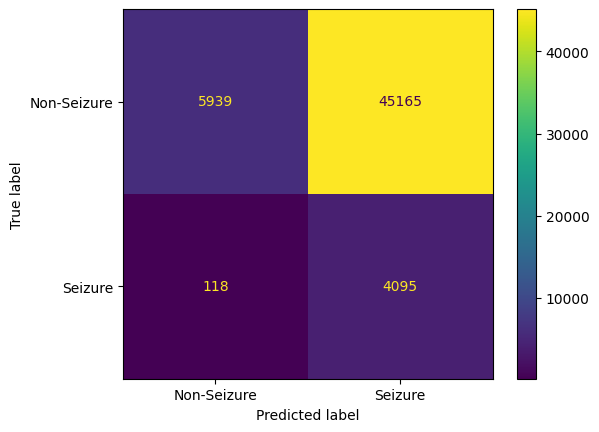

Decision Tree


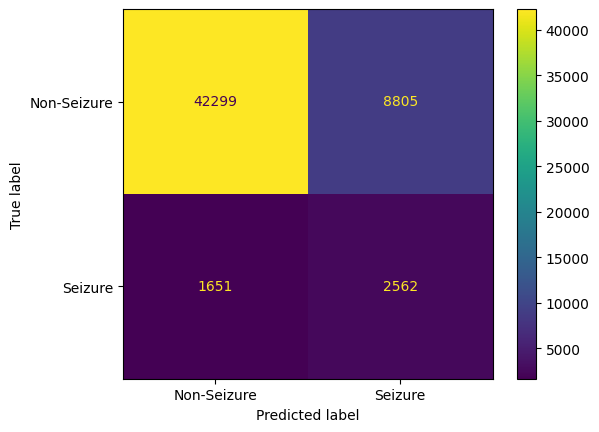

Random Forest


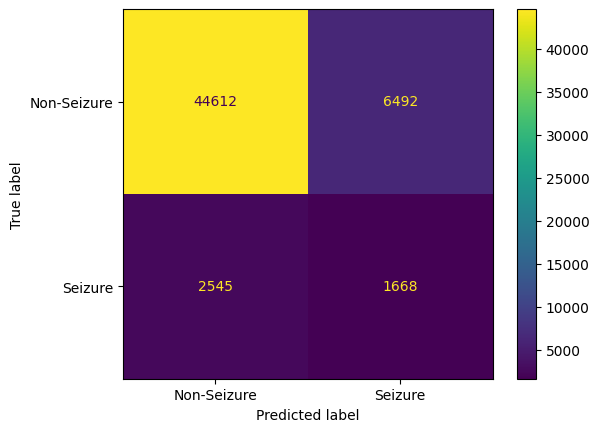

K-Nearest Neighbors


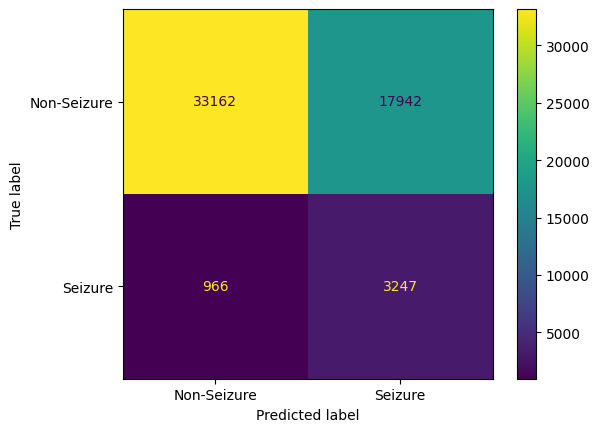

Non-Seizure      Seizure  accuracy  \
Metric    Classifier                                                 
f1-score  Decision Tree            0.889999     0.328883  0.810980   
          K-Nearest Neighbors      0.778158     0.255649  0.658188   
          Logistic Regression      0.207799     0.153161  0.181391   
          Random Forest            0.908031     0.269619  0.836632   
precision Decision Tree            0.962435     0.225389  0.810980   
          K-Nearest Neighbors      0.971695     0.153240  0.658188   
          Logistic Regression      0.980518     0.083130  0.181391   
          Random Forest            0.946031     0.204412  0.836632   
recall    Decision Tree            0.827704     0.608118  0.810980   
          K-Nearest Neighbors      0.648912     0.770710  0.658188   
          Logistic Regression      0.116214     0.971991  0.181391   
          Random Forest            0.872965     0.395917  0.836632   
support   Decision Tree        51104.000000  4213.000000  0.810980   
          K-Nearest Neighbors  51104.000000  4213.000000  0.658188   
          Logistic Regression  51104.000000  4213.000000  0.181391   
          Random Forest        51104.000000  4213.000000  0.836632   

                                  macro avg  weighted avg  
Metric    Classifier                                       
f1-score  Decision Tree            0.609441      0.847264  
          K-Nearest Neighbors      0.516904      0.738364  
          Logistic Regression      0.180480      0.203638  
          Random Forest            0.588825      0.859409  
precision Decision Tree            0.593912      0.906300  
          K-Nearest Neighbors      0.562467      0.909360  
          Logistic Regression      0.531824      0.912172  
          Random Forest            0.575222      0.889549  
recall    Decision Tree            0.717911      0.810980  
          K-Nearest Neighbors      0.709811      0.658188  
          Logistic Regression      0.544103      0.181391  
          Random Forest            0.634441      0.836632  
support   Decision Tree        55317.000000  55317.000000  
          K-Nearest Neighbors  55317.000000  55317.000000  
          Logistic Regression  55317.000000  55317.000000  
          Random Forest        55317.000000  55317.000000

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_Y = train_Y.ravel()
train_X = np.array(train_df)
test_Y = test_Y.ravel()
test_X = np.array(test_df)

for i, classifier in enumerate(classifiers):
    print(classifier_names[i])
    classifier.fit(train_X, train_Y)
    predictions = classifier.predict(test_X)
        
    classifier_score_df = pd.DataFrame(
                        classification_report(test_Y,
                                             predictions,
                                             target_names=['Non-Seizure',
                                                           'Seizure'],
                                             digits=2,
                                             output_dict=True))
    
    cm = confusion_matrix(test_Y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Seizure', 'Seizure'])
    disp.plot()
    plt.show()
    
    classifier_score_df.index.name = 'Metric'
    classifier_score_df['Classifier'] = classifier_names[i]
    classifier_score_df = classifier_score_df.set_index('Classifier', append=True)
      
    if i == 0:
        all_scores = classifier_score_df

    else:
        all_scores = pd.concat([all_scores, classifier_score_df])
        
all_scores.sort_index()

/standard/ivy-hip-rderi/ss4yd/.conda/envs/ood_env/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/standard/ivy-hip-rderi/ss4yd/.conda/envs/ood_env/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/standard/ivy-hip-rderi/ss4yd/.conda/envs/ood_env/lib/python3.13/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


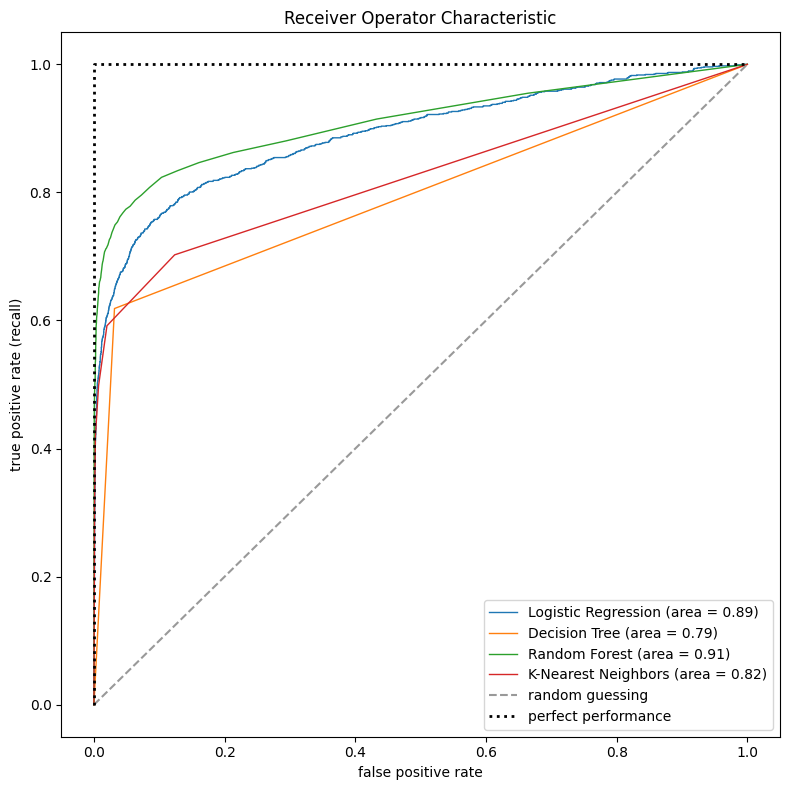

In [86]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import re

result_X = np.array(result_X_df)

X_train, X_val, y_train, y_val = train_test_split(result_X, result_Y, 
                                                    test_size=0.3, 
                                                    random_state=47, 
                                                    stratify=result_Y)

def ROC(classifiers, classifier_names, X_train, X_val, y_train, y_val):
  
    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(8, 8))
    # for each classifier...
    for i, classifer in enumerate(classifiers):
        # fit the pipeline
        probas = classifer.fit(X_train, y_train).predict_proba(X_val)

        # get the roc curve info
        fpr, tpr, thresholds = roc_curve(y_val, 
                                         probas[:, 1], 
                                         pos_label=1)

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, 
                 tpr, 
                 lw=1, 
                 label='{} (area = %0.2f)'.format(classifier_names[i]) %roc_auc)

    plt.plot([0, 1], 
           [0, 1], 
           linestyle='--', 
           color=(0.6, 0.6, 0.6), 
           label='random guessing')
    
    plt.plot([0, 0, 1], 
           [0, 1, 1], 
           lw=2, 
           linestyle=':', 
           color='black', 
           label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate (recall)')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right", fontsize ='medium')

    plt.tight_layout()
    plt.show()    
    

ROC(classifiers, classifier_names, X_train, X_val, y_train, 
    y_val)

In [ ]:
seizure_indices = np.where(result_Y)[0]
non_seizure_indices = np.where(np.invert(result_Y))[0]
undersampled_non_seizure_indices = non_seizure_indices[[np.random.choice(len(non_seizure_indices), len(seizure_indices), replace=False)]]
undersampled_indices = np.sort(np.append(seizure_indices, undersampled_non_seizure_indices))
result_X = result_X[undersampled_indices]
result_Y = result_Y[undersampled_indices].astype(int)

In [ ]:
# this method to find weights W1 , W2 as mentioned in paper
def findweights(X_test1,X_test2):
    acc = 0 
    W1 = 0 
    W2 = 0
    ma = 0 
    Ypred_ = newmodel.predict([X_test1,X_test2], verbose = 0)
    for i in np.arange(0,1,0.02):
        Ypred = (i*Ypred_[:,0] + (1-i)*Ypred_[:,1])
        Ypred = np.where(Ypred>=0,1,-1)
        acc = accuracy_score(y_test,Ypred)
        if ma <= acc :
            ma = acc
            W1 = i 
            W2 = 1 - i 
    
    return W1 ,W2     

In [ ]:
# this is a function to find the threshold as mentioned in paper
def findthrs(y_test,Ypred):
    fpr , tpr , thrs = roc_curve(y_test ,Ypred )
    acc = np.zeros(thrs.shape[0])
    Ypred_ = newmodel.predict([X_test1,X_test2], verbose = 0)
    Ypred_ = (0*Ypred_[:,0] +1* Ypred_[:,1])
        
    for i in range(0, thrs.shape[0], 100):
        acc[i] = accuracy_score(y_test,np.where(Ypred_>=thrs[i],1,-1))
    
    for i in range(np.argmax(acc)-100, np.min([np.argmax(acc)+100, thrs.shape[0]])):
        acc[i] = accuracy_score(y_test,np.where(Ypred_>=thrs[i],1,-1))

    return thrs[np.argmax(acc)]

In [ ]:
# function for finding area under curve value (AUC)
def findauc(Ypred , y_test):
    precision , recall , thrs = precision_recall_curve(y_test  , Ypred)
    a = auc(recall,precision)
    return a 

In [ ]:
def custom_loss_function(y_actual ,ypred):
    loss =  tf.compat.v1.keras.backend.sum(tf.compat.v1.keras.backend.maximum(0.0,1.- (y_actual * ypred)))

    y1 = ypred[:,0]
    y2 = ypred[:,1]
    m1 = tf.compat.v1.keras.backend.greater(tf.compat.v1.keras.backend.abs(y2-y1),1)


    extra = 0 
    # this is the additional reguralization term as mentioned in the paper
    extra = tf.compat.v1.keras.backend.sum(tf.compat.v1.keras.backend.switch(m1,tf.compat.v1.keras.backend.abs(y2-y1),0))

    loss  = loss +(0.001)* extra


    return loss 

In [ ]:
# function for created ICA features , using fastICA library in python
model1_components=100
def featuresICA(X_train,X_test):
    ica = FastICA(n_components = model1_components,)
    X_train1 = ica.fit_transform(X_train)
    X_test1 = ica.transform(X_test)
    sc1 = StandardScaler()
    X_train1 = sc1.fit_transform(X_train1)
    X_test1 = sc1.transform(X_test1)
    return X_train1,X_test1

In [ ]:
#function for creating 'psd' features, we use the inbuilt welch function for this 
model2_components = 54
def featurespsds(X_train,X_test):
    psds = []
    for i in range(X_train.shape[0]):
        freqs,psd = welch(X_train[i],fs = 50)
        psds.append([psd[1:model2_components+1]])

    X_train2 = np.array(psds)  
    X_train2 = np.reshape(X_train2,(X_train1.shape[0],model2_components))

    psds = []
    for i in range(X_test.shape[0]):
        freqs,psd = welch(X_test[i],fs = 50)
        psds.append([psd[1:model2_components+1]])

    X_test2 = np.array(psds)   
    X_test2 = np.reshape(X_test2,(X_test1.shape[0],model2_components))  

    # let us scale
    sc2 = StandardScaler()
    X_train2 = sc2.fit_transform(X_train2)
    X_test2 = sc2.transform(X_test2)
    #done scaling

    return X_train2 , X_test2

In [ ]:
model1 = Sequential()
model1.add(Dense(1, input_dim=model1_components, activation='linear', bias_initializer=initializers.Constant(0.01)))

model2 = Sequential()
model2.add(Dense(1, input_dim=model2_components, activation='linear', bias_initializer=initializers.Constant(0.01)))

mergedout = concatenate([model1.layers[0].output,model2.layers[0].output])

newmodel = Model([model1.layers[0].input , model2.layers[0].input],mergedout)

newmodel.compile(loss=custom_loss_function , optimizer = 'SGD')

In [ ]:
ss = StratifiedShuffleSplit(n_splits=10,test_size = 0.3,random_state= 0 )

In [ ]:
# initialize these values before running the loop
# initializing metrics
accuracy = 0 
sensitivity = 0 
specificity = 0 
f1score = 0
auc_score =  0 

In [ ]:
result_X = result_X.reshape(result_X.shape[0], 21, 1)
print(result_X.shape)
print(result_Y.shape)

In [ ]:
# # main function for implementing model
# # the model is implemented in three phases as mentioned in paper
# i = 0
# # running for 10sets of data as splited by K-fold 
# for train_index , test_index in ss.split(result_X,result_Y):
#     print('iteration '+str(i))
#     i+=1
#     # phase 1 preparing data
#     X_train, X_test = result_X[train_index], result_X[test_index]
#     y_train, y_test = result_Y[train_index], result_Y[test_index]
#     X_train1,X_test1 = featuresICA(X_train,X_test)
#     X_train2,X_test2 = featurespsds(X_train,X_test)
#     # done preparing data
#     #time to train
#     # phase 2 training the model
#     newmodel.fit([X_train1,X_train2],y_train,epochs = 50 , batch_size=20)
    
#     print("finding weights")
#     # phase 3 tuning the model 
#     W1,W2 = findweights(X_test1, X_test2)
#     print("weights: " + str(W1) + "," + str(W2))
#     Ypred = newmodel.predict([X_test1,X_test2], verbose = 0)
#     Ypred = W1 * Ypred[:,0] + W2 * Ypred[:,1]

#     # graphs (ROC , precision vs recall) are ploted in 10th step in 10-fold cross validation
#     if i==10:
   
#         fpr , tpr , thrs = roc_curve(y_test , Ypred)
#         plt.plot(fpr , tpr)
#         plt.title('ROC curve for ABCD vs E')
#         plt.xlabel('False positive rate')
#         plt.ylabel('True positive rate')
#         plt.savefig('ROC ABCD vs E.png')
#         plt.show()

#         precision , recall , thrs = precision_recall_curve(y_test  , Ypred)
#         plt.plot(recall , precision)
#         plt.title('Precision vs Recall for ABCD vs E')
#         plt.xlabel('Recall')
#         plt.ylabel('Precision')
#         plt.savefig('PvsR_ABCD vs E.png')   
#         plt.show() 


    
  
#     # finding values of different metrics mentioned in table[2] of paper
#     # let us find precision and recall
#     print("finding auc")
#     auc_score+=findauc(Ypred,y_test)
#     #now lets find the best threshold value 
#     print("finding threshold")
#     threshold = findthrs(y_test,Ypred)
#     Ypred = np.where(Ypred>=threshold,1,-1)
#     # now let's evaluate the model
#     # let's us find the confusion matrix from which we can find values
#     cm = confusion_matrix(y_test,Ypred)
#     specificity += cm[1][1]/(cm[0][1]+cm[1][1])
#     sensitivity += cm[0][0]/(cm[0][0]+cm[1][0])
#     accuracy += (cm[0][0] + cm[1][1])/(cm[0][0]+ cm[0][1] + cm[1][0] + cm[1][1])
#     precision = (cm[0][0]/(cm[0][0]+cm[0][1]))
#     recall = cm[1][1] /(cm[1][1]+cm[1][0])
#     f1 = 2.0 * ( precision * recall)/(precision + recall)
#     f1score+=f1
#     print(accuracy_score(y_test,Ypred))

In [ ]:
#  # these are the averaged values over 10 folds
# accuracy = accuracy*10
# sensitivity = sensitivity*10
# specificity = specificity*10
# f1score = f1score/10
# auc_score = auc_score/10
# print('Accuracy '+ str(accuracy))
# print('Sensitivity  '+ str(sensitivity))
# print('Specificity ' + str(specificity))
# print('f1 score  '+ str(f1score))
# print('auc value '+str(auc_score))

In [ ]:
# # sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
# # sss.get_n_splits(result_X, result_Y)
# # X_train_set=[]
# # X_test_set=[]
# # Y_train_set=[]
# # Y_test_set=[]
# # for train_index, test_index in sss.split(result_X, result_Y):
# #     X_train, X_test = result_X[train_index], result_X[test_index]
# #     y_train, y_test = result_Y[train_index], result_Y[test_index]
    
# #     X_train_set.append(X_train)
# #     X_test_set.append(X_test)
# #     Y_train_set.append(y_train)
# #     Y_test_set.append(y_test)

# # X_train_set = np.array(X_train_set)
# # Y_train_set = np.array(Y_train_set)
# # X_test_set = np.array(X_test_set)
# # Y_test_set = np.array(Y_test_set)

# print(X_train_set.shape)
# print(Y_train_set.shape)

# print(X_test_set.shape)
# print(Y_test_set.shape)

# def crop(x,mag,trace_length,randloc=True):
#     if len(x.shape)>1:
#         aug_x=np.zeros((trace_length,x.shape[1]))
#     else:
#         aug_x=np.zeros((trace_length))
#     # shift left or right by maximum of 50% of trace (at absolute valute of setting 10)
#     # if entire trace can fit with perscribed shift - randomly locate in array
#     #print(x.shape[0])
#     if mag==[0,0]:  ## randomly locate trace within aug_x bounded by length of input
#         if randloc==True:  #used to facilitate testing
#             if x.shape[0]<trace_length:
#                 shift=np.random.randint(0,trace_length-x.shape[0]) 
#                 aug_x[shift:(shift+x.shape[0]),:]=x
#             elif x.shape[0]==trace_length:
#                 aug_x[0:x.shape[0],:]=x
#             else:
#                 shift=np.random.randint(0,x.shape[0]-trace_length) # randomly cuts off beginning of trace (end would overhang)
#                 aug_x=x[shift:trace_length+shift]
#         else:
#             if x.shape[0]>trace_length:
#                 x=x[0:trace_length,:]
#             aug_x[0:x.shape[0],:]=x


        
        
        
#         return aug_x
#     else:
#         if (trace_length-x.shape[0]) > (trace_length*(np.max(np.abs(mag)))/20): # if max possible shift is less than we just randomly locate in trace
#             shift=np.random.randint(0,trace_length-x.shape[0]) 
#             aug_x[shift:(shift+x.shape[0]),:]=x    
#             return aug_x
#         elif mag[0]==mag[1]:
#             shift=int(mag[0]*(x.shape[0]/20))
#         else:
#             shift=np.random.randint(int(mag[0]*(trace_length/20)),int(mag[1]*(trace_length/20))) 
#     #offset shift to start with trace 'centered'
#     #print('long trace')
#     #print(shift)
#     shift = shift - int((x.shape[0]-trace_length)/2)
#     #print(shift)
#     if shift<0: # Negative shifts go left -cut 
#         x=x[-shift:]
#         if x.shape[0]>trace_length:
#             x=x[:trace_length]
#         aug_x[:x.shape[0]]=x
#     else: # Positive Shifts go right       
#         if (x.shape[0]+shift)>trace_length:
#             x=x[:-(x.shape[0]+shift-trace_length)]
#             aug_x[shift:]=x
#         else:
#             aug_x[shift:(shift+x.shape[0])]=x
#     return aug_x

# from itertools import repeat, chain
# def warp(x,mag,minLength,maxLength):  
#     # warp takes mag of [n,n] where n is > 0 and can be fraction
#     # n=.5 would be a minimum contraction of 50%
#     # min length/max length used to set limits
    
#     ### Improve later by adding random shifts left/right for contracting warps to increase diversity of samples
#     ### Improve later by adding to a class so that we don't need to do all the magnitude calculations every time
#     ### Improve later by using rolling average during contracting warps
    
#     if mag==[1,1]:
#         return x  # no warping
#     else:
#         # get lower limit
#         lower_limit = minLength/x.shape[0] # minimum bound for contracting warps
#         upper_limit = maxLength/x.shape[0]

#         if mag[0]<lower_limit:
#             mag[0]=lower_limit
#         if mag[1]>upper_limit:
#             mag[1]=upper_limit
#         #print(x.shape)
#         #print(str(mag[0])+' to'+str(mag[1]))
#         # get warp magnitude
#         warp=np.random.uniform(mag[0],mag[1])
#         #print('warp: ' + str(warp))
#         ### translate warp, start with key that matches expanding/contracting algorithms
#         # Contracting warps will delete every nth row
#         # Slow Contracting warps will delete every nth row
#         contracting_slow=np.arange(3,21)
#         contracting_slow_values=1-1/contracting_slow
#         contslowkey=list(repeat('contslow',contracting_slow_values.shape[0]))
#         contracting_slow_values
#         # Contracting Warps delete multipe rows
#         contracting=np.arange(1,50)
#         contracting_values=1/contracting
#         contkey=list(repeat('cont',contracting_values.shape[0]))
#         # Slow Expanding Warps add an imputed value every nth row
#         slow_exp = np.arange(1,10)
#         slow_exp_values = 1 + 1/slow_exp
#         slowkey=list(repeat('slow_exp',slow_exp_values.shape[0]))
#         # Fast Expanding Warps add n imputed values every other row
#         fast_exp = np.arange(2,30)
#         fast_exp_values = 1 + fast_exp
#         fastkey=list(repeat('fast_exp',fast_exp_values.shape[0]))

#         keys=contslowkey+contkey+slowkey+fastkey
#         values=list(contracting_slow_values)+list(contracting_values)+list(slow_exp_values)+list(fast_exp_values)
#         settings=list(contracting_slow)+list(contracting)+list(slow_exp)+list(fast_exp)
        

#         if mag[0]==mag[1]:
#             warp=mag[0]  # only use for testing
        
#         array = np.asarray(values)
#         idx = (np.abs(array - warp)).argmin()
#         setting=settings[idx]
#         warp_type=keys[idx]
#         #print(warp_type)
#         #print('setting:'+str(setting))
#         #print('nearest:'+str(array[idx]))
                
#         #something like if (sub_data.shape[0]-(sub_data.shape[0]/warp))>=.3*self.length: and one controlling greater than. 
#         if warp==1:
#             return x
#         if warp_type=="slow_exp":
#             warp_e=setting
#             df=pd.DataFrame(x) 
#             s = pd.Series(np.nan, df.columns)
#             f = lambda d: d.append(s, ignore_index=True)
#             grp = np.arange(len(df)) // warp_e #up to 1/10
#             df=df.groupby(grp, group_keys=False).apply(f).reset_index(drop=True)
#             df=df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(method='ffill')
#             if len(x.shape)>1:
#                 x_aug_temp=np.array(df)[0:df.shape[0]]
#             else:
#                 x_aug_temp=np.array(df)[0:df.shape[0]][0:,0]           
#             return x_aug_temp
#         elif warp_type=='cont':
#             warp_c=setting
#             x_aug_temp=x[0::warp_c]
#             return x_aug_temp
#         elif warp_type=='contslow':
#             warp_cs=setting
#             x_aug_temp=np.delete(x, slice(None, None, warp_cs),axis=0)
#             return x_aug_temp
#         else:
#             warp_ef=setting
#             df=pd.DataFrame(x)
#             z=np.array(pd.Series(np.nan, df.columns))
#             z=np.vstack(list(repeat(z,warp_ef)))
#             df=pd.DataFrame(np.row_stack(list(chain(*zip(x[0::1], repeat(z))))), columns=df.columns)
#             df=df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(method='ffill')
#             if len(x.shape)>1:
#                 x_aug_temp=np.array(df)[0:df.shape[0]]
#             else:
#                 x_aug_temp=np.array(df)[0:df.shape[0]][0:,0]           
#             return x_aug_temp

# def jitter(x,mag):
#     # add random normal noise up to 
#     return x+np.random.normal(scale=.005*mag,size=x.shape)

# def scale(x,mag):
#     if mag==[0,0]:
#         return x
#     else:
#         if mag[0]==mag[1]:
#             scale_f=mag[0]
#         else:
#             scale_f=np.random.randint(mag[0],mag[1])
#     if scale_f==0:
#         return x
#     if scale_f>0:
#         x=x+.35*x*(scale_f/10)
#         return x
#     if scale_f<0:
#         x=x*(1+.35*(scale_f/10))
#         return x

# def get_1d_model(input_data, layer1KernelSize=5, layer1Stride=3, layer1Poolsize=3, flatten=False,
#                         kernelSize=3, stride=1,poolSize=2, nlayers=5, batchnorm=False, dropout=0.2,
#                         nfilters=256, actfun='relu', noise=False):
    
#     x = Conv1D(nfilters, kernel_size=layer1KernelSize, activation='relu', padding='same', strides=layer1Stride)(input_data)
#     if noise==True:
#         x=GaussianNoise(.2)(input_data)
#         x = Conv1D(nfilters, kernel_size=layer1KernelSize, activation='relu', padding='same', strides=layer1Stride)(x)
#     x = MaxPooling1D(layer1Poolsize, padding='same')(x)
#     if batchnorm==True:
#         x = BatchNormalization()(x)
#     if dropout>0:
#         x = Dropout(rate=dropout*0.5)(x)
#     if nlayers>2:
#         for i in range(0,nlayers-2):
#             x = Conv1D(int(nfilters*.5), kernel_size=kernelSize, activation='relu', padding='same',strides=stride)(x)
#             x = MaxPooling1D(poolSize, padding='same')(x)
#             if batchnorm==True:
#                 x = BatchNormalization()(x)
#             if dropout>0:
#                 x = Dropout(rate=dropout)(x)
#     x = Conv1D(int(nfilters*.5), kernel_size=kernelSize, activation='relu', padding='same',strides=stride, name='finalout')(x)
    
#     x = MaxPooling1D(poolSize, padding='same')(x)
    
#     if batchnorm==True:
#         x = BatchNormalization()(x)
#     if dropout>0:
#         x = Dropout(rate=dropout*.5)(x)

#     if flatten==False:
#         x = GlobalMaxPooling1D()(x)
#     else:
#         x = Flatten()(x)    
#     x = Dense(21, activation='relu')(x)
#     y = Dense(1, activation='softmax', name='prediction')(x)
    
#     model = Model(input_data, y)
#     model.summary()
#     return model

# results=[]
# precision=[]
# recall=[]
# f1=[]
# result_X = result_X.reshape(result_X.shape[0], 21, 1)
# for i in range(0,10):

#     input_data = Input(shape=result_X.shape[1:]) 
    
#     X_train = X_train_set[i]
#     print("first x train")
#     print(X_train.shape)
#     X_test = X_test_set[i]
#     Y_train = Y_train_set[i]
#     Y_test = Y_test_set[i]
#     X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, shuffle=True, test_size=.3, random_state=0, stratify=Y_train)
#     print("x train after split")
#     print(X_train.shape)
    
#     augment = False
#     if augment:
#         augment_percent = 0.4
#         result_X_aug = []
#         for result_data in X_train:
#             #result_temp = warp(result_data, [0.75,2], minLength=50, maxLength=350)
#             result_temp = scale(result_temp, [-1,1])
#             result_temp = jitter(result_data, 2)
#             result_temp = crop(result_temp, [-5,5], trace_length=result_data.shape[0])
#             result_X_aug.append(result_temp)
#         result_X_aug = np.array(result_X_aug)
#         num_copies = int(1/augment_percent)
#         X_train_copy = X_train
#         Y_train_copy = Y_train
#         for j in range(0,num_copies-1):
#             X_train = np.append(X_train, X_train_copy, axis=0)
#             Y_train = np.append(Y_train, Y_train_copy, axis=0)
#         X_train = np.append(X_train, result_X_aug, axis=0)
#         Y_train = np.append(Y_train, Y_train_copy, axis=0)
        
#     from numpy.random import seed
#     seed(2)
    
#     # Best Models So far
#     model = get_1d_model(input_data, nfilters=64, flatten=False, 
#                          layer1KernelSize=5, layer1Stride=3, layer1Poolsize=3, 
#                          kernelSize=3, stride=1,poolSize=2, nlayers=8, 
#                          batchnorm=False, dropout=0, noise=False )

#     opt1=Adam(learning_rate=.00001) 
    
#     model.compile(loss='binary_crossentropy', optimizer=opt1,  metrics=['accuracy'])

#     earlystopper = EarlyStopping(monitor='val_acc', mode='min', patience=100,min_delta=.001, verbose=1,restore_best_weights=True)
#     #checkpointer = ModelCheckpoint('bestMod.model', verbose=0, save_best_only=True) #validation_data=(X_val, Y_val),

#     model.fit(X_train, Y_train, batch_size=12,validation_data=(X_val, Y_val), shuffle=True, verbose=1, epochs=300, callbacks=[earlystopper])

#     #model=load_model('bestMod.model')

#     model.evaluate(X_test,Y_test)
    
#     answer=Y_test.argmax(axis=1)
#     prediction=model.predict(X_test).argmax(axis=1)
#     ## Calculate Precision and Recall
#     tfs=prediction==answer
#     c_precision=[]
#     c_recall=[]
#     c_F1=[]
#     for k in range(0,Y_test.shape[1]):
#         class_total=np.sum(Y_test[:,k]==1)
#         print(class_total)
#         print(class_total)
#         TPs=np.sum(tfs[Y_test[:,k]==1]) #True positives
#         FPs=np.sum(~tfs[Y_test[:,k]!=1])
#         c_precision.append(TPs/(TPs+FPs))
#         c_recall.append(TPs/class_total)
#         c_F1.append(2/(c_recall[k]**-1+c_precision[k]**-1))
#     c_F1=tuple(c_F1)
#     c_precision=tuple(c_precision)
#     c_recall=tuple(c_recall)
#     print(c_F1)
#     print(c_precision)
#     print(c_recall)
#     precision.append(c_precision)
#     recall.append(c_recall)  
#     f1.append(c_F1)      
#     Y_test.shape
    
#     model.summary()

#     acc=sum(tfs)/X_test.shape[0]
#     results.append(acc)
#     print('Exp ' + str(i) + ', accuracy:' + str(acc))

# print('Mean Acc')
# print(np.mean(np.array(results)))
# print('Mean Precision')
# print(np.mean(np.array(precision),axis=0))
# print('Mean Recall')
# print(np.mean(np.array(recall),axis=0))
# print('Mean F1')
# print(np.mean(np.array(f1),axis=0)) 

# import plotly.express as px

# plotdf=pd.DataFrame()
# plotdf['ecog']=test_sample[0]
# plotdf['label']=test_label[0]
# plotdf['preds']=preds

# print(f"F1 Score: {f1_score(plotdf['label'], plotdf['preds'])}")

# plt.figure(figsize=(20,8))
# sns.lineplot(data=plotdf, x=plotdf.index, y="ecog", hue="label")
# plt.show()

# plt.figure(figsize=(20,8))
# sns.lineplot(data=plotdf, x=plotdf.index, y="ecog", hue="preds")
# plt.show()

# color_discrete_map = {1:'red',0:'blue'}

# fig = px.line(plotdf, x=plotdf.index, y="ecog", color='label', color_discrete_map=color_discrete_map)
# fig.show()

# fig = px.line(plotdf, x=plotdf.index, y="ecog", color='preds', markers='.', color_discrete_map=color_discrete_map)
# fig.show()

